In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16
from torchvision import transforms
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Image Transformation Network
This is based on Justin C. Johnson's paper, [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf).
Here, we are going to make the proposed network for generating the end image (as in the convolutional neural network the will learn weights in order to efficiently calculate how to create an image based on a style)

### Architecture
![Architecture](./images/transformation-network-table.PNG)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # For the transformation network, the authors only used 3x3 convolutions
        self.conv = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.out_channels,
                               kernel_size = 3)
        self.batch_norm = nn.InstanceNorm2d(self.out_channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # First convolution
        orig_x = x.clone()
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        
        # Second convolution
        x = self.conv(x)
        x = self.batch_norm(x)
        
        # Now add the original to the new one (and use center cropping)
        # Calulate the different between the size of each feature (in terms 
        # of height/width) to get the center of the original feature
        height_diff = orig_x.size()[2] - x.size()[2]
        width_diff = orig_x.size()[3] - x.size()[3]
        
        # Add the original to the new (complete the residual block)
        x = x + orig_x[:, :,
                                 height_diff//2:(orig_x.size()[2] - height_diff//2), 
                                 width_diff//2:(orig_x.size()[3] - width_diff//2)]
        
        return x

In [4]:
class ImageTransformationNetwork(nn.Module):
    def __init__(self):
        super(ImageTransformationNetwork, self).__init__()
        # Use reflection padding to keep the end shape
        self.ref_pad = nn.ReflectionPad2d(40)
        
        # Initial convolutions
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 32,
                               kernel_size = 9,
                               padding = 6,
                               padding_mode = 'reflect')
        
        self.conv2 = nn.Conv2d(in_channels = 32,
                               out_channels = 64,
                               kernel_size = 3,
                               stride = 2)
        
        self.conv3 = nn.Conv2d(in_channels = 64,
                               out_channels = 128,
                               kernel_size = 3,
                               stride = 2)
        
        # Residual Blocks
        self.resblock1 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock2 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock3 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock4 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock5 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        # Transpose convoltutions
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=128,
                                             out_channels=64,
                                             kernel_size=2,
                                             stride=2)
        
        self.trans_conv2 = nn.ConvTranspose2d(in_channels=64,
                                              out_channels=32,
                                              kernel_size=2,
                                              stride=2)
        
        # End with one last convolution
        self.conv4 = nn.Conv2d(in_channels = 32,
                               out_channels = 3,
                               kernel_size = 9,
                               padding = 4,
                               padding_mode = 'reflect')
        
    def forward(self, x):
        # Apply reflection padding
        x = self.ref_pad(x)
        
        # Apply the initial convolutions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Apply the residual blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)        
        
        #  Apply the transpose convolutions
        x = self.trans_conv1(x)
        x = self.trans_conv2(x)
        
        # Apply the final convolution
        x = self.conv4(x)
        
        return x

In [5]:
# Test to confirm the residual network works
resblock = ResidualBlock(128, 128)
test = torch.randn(2, 128, 84, 84)
out = resblock(test)
print(out.size())

torch.Size([2, 128, 80, 80])


In [6]:
# Test to confirm the transormational network works
transformation_net = ImageTransformationNetwork()
test = torch.randn(2, 3, 256, 256)
out = transformation_net(test)
print(out.size())

torch.Size([2, 3, 256, 256])


### Cost Functions
Now we must implement the different cost functions

Style Relu Indices: 3, 8, 15, 22  
Content Relu Index: 15

In [7]:
class ForwardVGG16(torch.nn.Module):
    def __init__(self):
        super(ForwardVGG16, self).__init__()
        features = list(vgg16(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()
        
    def forward(self, x, style):
        results = []
        for i, model in enumerate(self.features):
            x = model(x)
            if style:
                if i in {3, 8, 15, 22}:
                    results.append(x)
            
            else:
                if i == 15:
                    results.append(x)
        
        return results

forward_vgg = ForwardVGG16()

In [8]:
def normalize_batch(batch):
    """
    Before we send an image into the VGG16, we have to normalize it
    """
    vgg_means = [123.68, 116.779, 103.94]
    ret = torch.zeros(*batch.size())
    ret[:, 0, :, :] = batch[:, 0, :, :] - vgg_means[0]
    ret[:, 1, :, :] = batch[:, 1, :, :] - vgg_means[1]
    ret[:, 2, :, :] = batch[:, 2, :, :] - vgg_means[2]
    return ret

In [43]:
def denormalize_batch(batch):
    vgg_means = [123.68, 116.779, 103.94]
    ret = torch.zeros(*batch.size())
    ret[:, 0, :, :] = batch[:, 0, :, :] + vgg_means[0]
    ret[:, 1, :, :] = batch[:, 1, :, :] + vgg_means[1]
    ret[:, 2, :, :] = batch[:, 2, :, :] + vgg_means[2]
    return ret

In [10]:
def add_noise(batch):
    """
    For the input image, we have to add noise so that the loss between the content image and 
    input image is not 0
    """
    mean = 0.0
    std = 10.0
    ret = batch + np.random.normal(mean, std, batch.shape)
    ret = np.clip(batch, 0, 255)
    return ret

In [11]:
def squared_norm(matrix):
    """
    Computes the squared normalization given a matrix
    """
    batches, channels, height, width = matrix.size()
    return (1/(channels * height * width)) * torch.square(matrix)

In [12]:
def compute_gram(matrix):
    """
    Computes the gram matrix
    """
    batches, channels, height, width = matrix.size()
    return (1/(channels * height * width)) * (torch.matmul(matrix.view(batches, channels, -1),
            torch.transpose(matrix.view(batches, channels, -1), 1, 2)))


In [13]:
def compute_fro_norm(matrix):
    """
    Computes the frobenius norm
    """
    batches, height, width = matrix.size()
    return torch.norm(matrix.view(batches, 1, -1), 'fro', dim=2)

In [44]:
def content_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, False)
    target_layers = forward_vgg(target_norm, False)
    
    accumulated_loss = 0
    for layer in range(len(input_layers)):
        accumulated_loss = accumulated_loss + torch.sum(squared_norm(input_layers[layer] - target_layers[layer])) / input.size()[0]
    
    return accumulated_loss

In [45]:
def style_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, True)
    target_layers = forward_vgg(target_norm, True)
    
    accumulated_loss = 0
    for layer in range(len(input_layers)):
        accumulated_loss = accumulated_loss + torch.sum(torch.square(compute_fro_norm(compute_gram(input_layers[layer]) - compute_gram(target_layers[layer])))) / input.size()[0]
    
    return accumulated_loss

In [62]:
def total_variation_cost(input):
    tvloss = (
        torch.sum(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + 
        torch.sum(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
    )
    return tvloss

In [65]:
def total_cost(input, targets):
    REG_LAMBDA = 1e-5
    content, style = targets
    closs = content_cost(input, content)
    sloss = style_cost(input, style)
    tvloss = total_variation_cost(input)
    
    return REG_LAMBDA * (closs + sloss + tvloss)
    

### Data Loading

In [34]:
# Constants
IMG_DIMENSIONS = (256, 256)
DATA = list(glob.iglob('data/content_images/*'))
STYLE_IMAGE = np.asarray(Image.open('data/style_image.png').resize(IMG_DIMENSIONS)).transpose(2, 0, 1)[0:3]

# Make the style image a batch and convert
STYLE_IMAGE = STYLE_IMAGE.reshape(1, 3, 256, 256)
MAX_TRAIN = 60000
MAX_VAL = 70000
TOTAL_DATA = len(DATA)

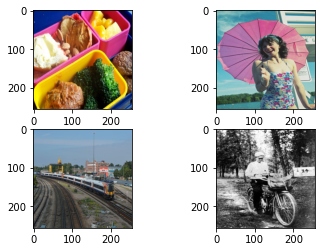

In [32]:
def show_sample_images():
    f, axarr = plt.subplots(2,2)
    
    # Show colored images
    axarr[0,0].imshow(np.asarray(Image.open(DATA[0]).resize(IMG_DIMENSIONS)))
    axarr[0,1].imshow(np.asarray(Image.open(DATA[4]).resize(IMG_DIMENSIONS)))
    axarr[1,0].imshow(np.asarray(Image.open(DATA[8]).resize(IMG_DIMENSIONS)))
    
    # Grayscale example
    grayscale = np.asarray(Image.open(DATA[13]).resize(IMG_DIMENSIONS))
    grayscale = np.stack((grayscale, grayscale, grayscale)).transpose(1, 2, 0)
    axarr[1,1].imshow(grayscale)
    
show_sample_images()

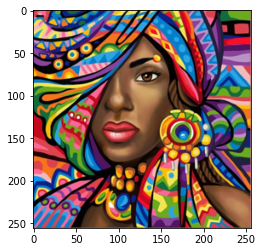

In [36]:
# Show the chosen style image
plt.imshow(STYLE_IMAGE[0].transpose(1, 2, 0))

In [38]:
def load_training_batch(current_batch, batch_size, set_type):
    """
    Load different batches of data (essentially a custom data loader for training, validation, and testing)
    """
    # The initial position is where we want to start getting the batch
    # So it is the starting index of the batch
    initial_pos = current_batch * batch_size
    
    # List to store the images
    images = []
    
    # Make sure the batch is within the [0, MAX_TRAIN]
    if set_type == 'train':
        if initial_pos + batch_size > MAX_TRAIN:
            batch_size = MAX_TRAIN - initial_pos
    
    # Make sure the batch is within the [MAX_TRAIN, MAX_VAL]
    elif set_type == 'val':
        initial_pos = MAX_TRAIN + initial_pos
        if initial_pos + batch_size > MAX_VAL:
            batch_size = MAX_VAL - initial_pos
    
    # Make sure the batch is within the [MAX_VAL, TOTAL_DATA]
    elif set_type == 'test':
        initial_pos = MAX_VAL + initial_pos
        if initial_pos + batch_size > TOTAL_DATA:
            batch_size = TOTAL_DATA - initial_pos

    for f in DATA[initial_pos:initial_pos + batch_size]:
        # Resize the image to 256 x 256
        image = np.asarray(Image.open(f).resize(IMG_DIMENSIONS))
        
        # If the image is grayscale, stack the image 3 times to get 3 channels
        if image.shape == IMG_DIMENSIONS:
            image = np.stack((image, image, image))
            images.append(image)
            continue
            
        # Transpose the image to have channels first
        image = image.transpose(2, 0, 1)
        images.append(image)
    
    return np.array(images)

In [194]:
train_batch = load_training_batch(0, 64, 'train')

In [224]:
style_cost(torch.from_numpy(train_batch).float(), torch.from_numpy(STYLE_IMAGE).float())

tensor(1.5296e+09, grad_fn=<AddBackward0>)

In [231]:
content_cost(add_noise(torch.from_numpy(train_batch).float()), torch.from_numpy(train_batch).float())

tensor(2742.9099, grad_fn=<AddBackward0>)

### Training

In [66]:
BATCH_SIZE = 4
STYLE_IMAGE_TENSOR = torch.from_numpy(np.copy(STYLE_IMAGE)).float()
transformation_net = ImageTransformationNetwork()
transformation_net.train()
opt = optim.Adam(transformation_net.parameters(), lr=1e-3)
REG_LAMBDA = 1e-5

In [ ]:
for epoch in range(3):
    epoch_loss = 0
    for batch, _ in enumerate(range(0, MAX_TRAIN, BATCH_SIZE)):
            # The content batch is the same as the train batch, except train batch has noise added to it
            train_batch = load_training_batch(batch, BATCH_SIZE, 'train')
            content_batch = np.copy(train_batch)
            # Add noise to the training batch
            train_batch = add_noise(train_batch)

            # Convert the batches to tensors
            train_batch = torch.from_numpy(train_batch).float()
            content_batch = torch.from_numpy(content_batch).float()

            # Zero the gradients
            opt.zero_grad()

            # Forward propagate
            gen_images = transformation_net(train_batch)

            # Compute loss
            loss = total_cost(gen_images, [content_batch, STYLE_IMAGE_TENSOR])

            # Backprop and apply gradients
            loss.backward()
            opt.step()

            print("Batch: {}".format(batch), "Loss: {:f}".format(loss))
            epoch_loss += loss


Batch: 0 Loss: 47066.171875
